# Análise não-linear de séries temporais
Este tipo de análise consiste em um conjunto de metodologias que começaram a ser desenvolvidas na década de 1990 com a finalidade de estudar sistemas complexos. Uma [boa revisão](https://aip.scitation.org/doi/pdf/10.1063/1.4917289?casa_token=J6ENq2j7UZYAAAAA:zHvGR93etcwS0jZPxq1Gu3sw1xPcVefi89Qh3lepPIFxUm6zkQcdnGPXPVbR3Rvo9qg_LFdtlMzQ) deste assunto nos informa que se trata de buscar caracterizar o sistema dinâmico por trás do fenômeno estudado, frequentemente, um sistema caótico deterministico.

In [3]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score as MI
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib notebook

## Reconstrução do espaço de estados
A reconstrução do espaço de estados do sistema dinâmico é a pedra fundamental desta metodologia. Para isso normalmente usamos Retratos de fase $m$-dimensionais atrasados da nossa série $y(t)$:

$$\overrightarrow{R}(t)=\left[y(t), y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)\right]$$

Vamos explorar esta reconstrução com uma série simulada a partir das equações de Rössler.

\begin{align}
\frac{dx}{dt}&=-y-z\\
\frac{dy}{dt}&=x+a y\\
\frac{dz}{dt}&=b + z  (x - c)
\end{align}

In [4]:
def rossler(Y,t,*pars):
    x,y,z = Y
    a,b,c = pars
    return [
        -y-z,
        x+(a*y),
        b+z*(x-c)
    ]

In [5]:
inits = [4,4,5]
a,b,c = 0.2, 0.2, 5.7
trange = range(20000)
res = odeint(rossler,inits,trange, args=(a,b,c))

<IPython.core.display.Javascript object>


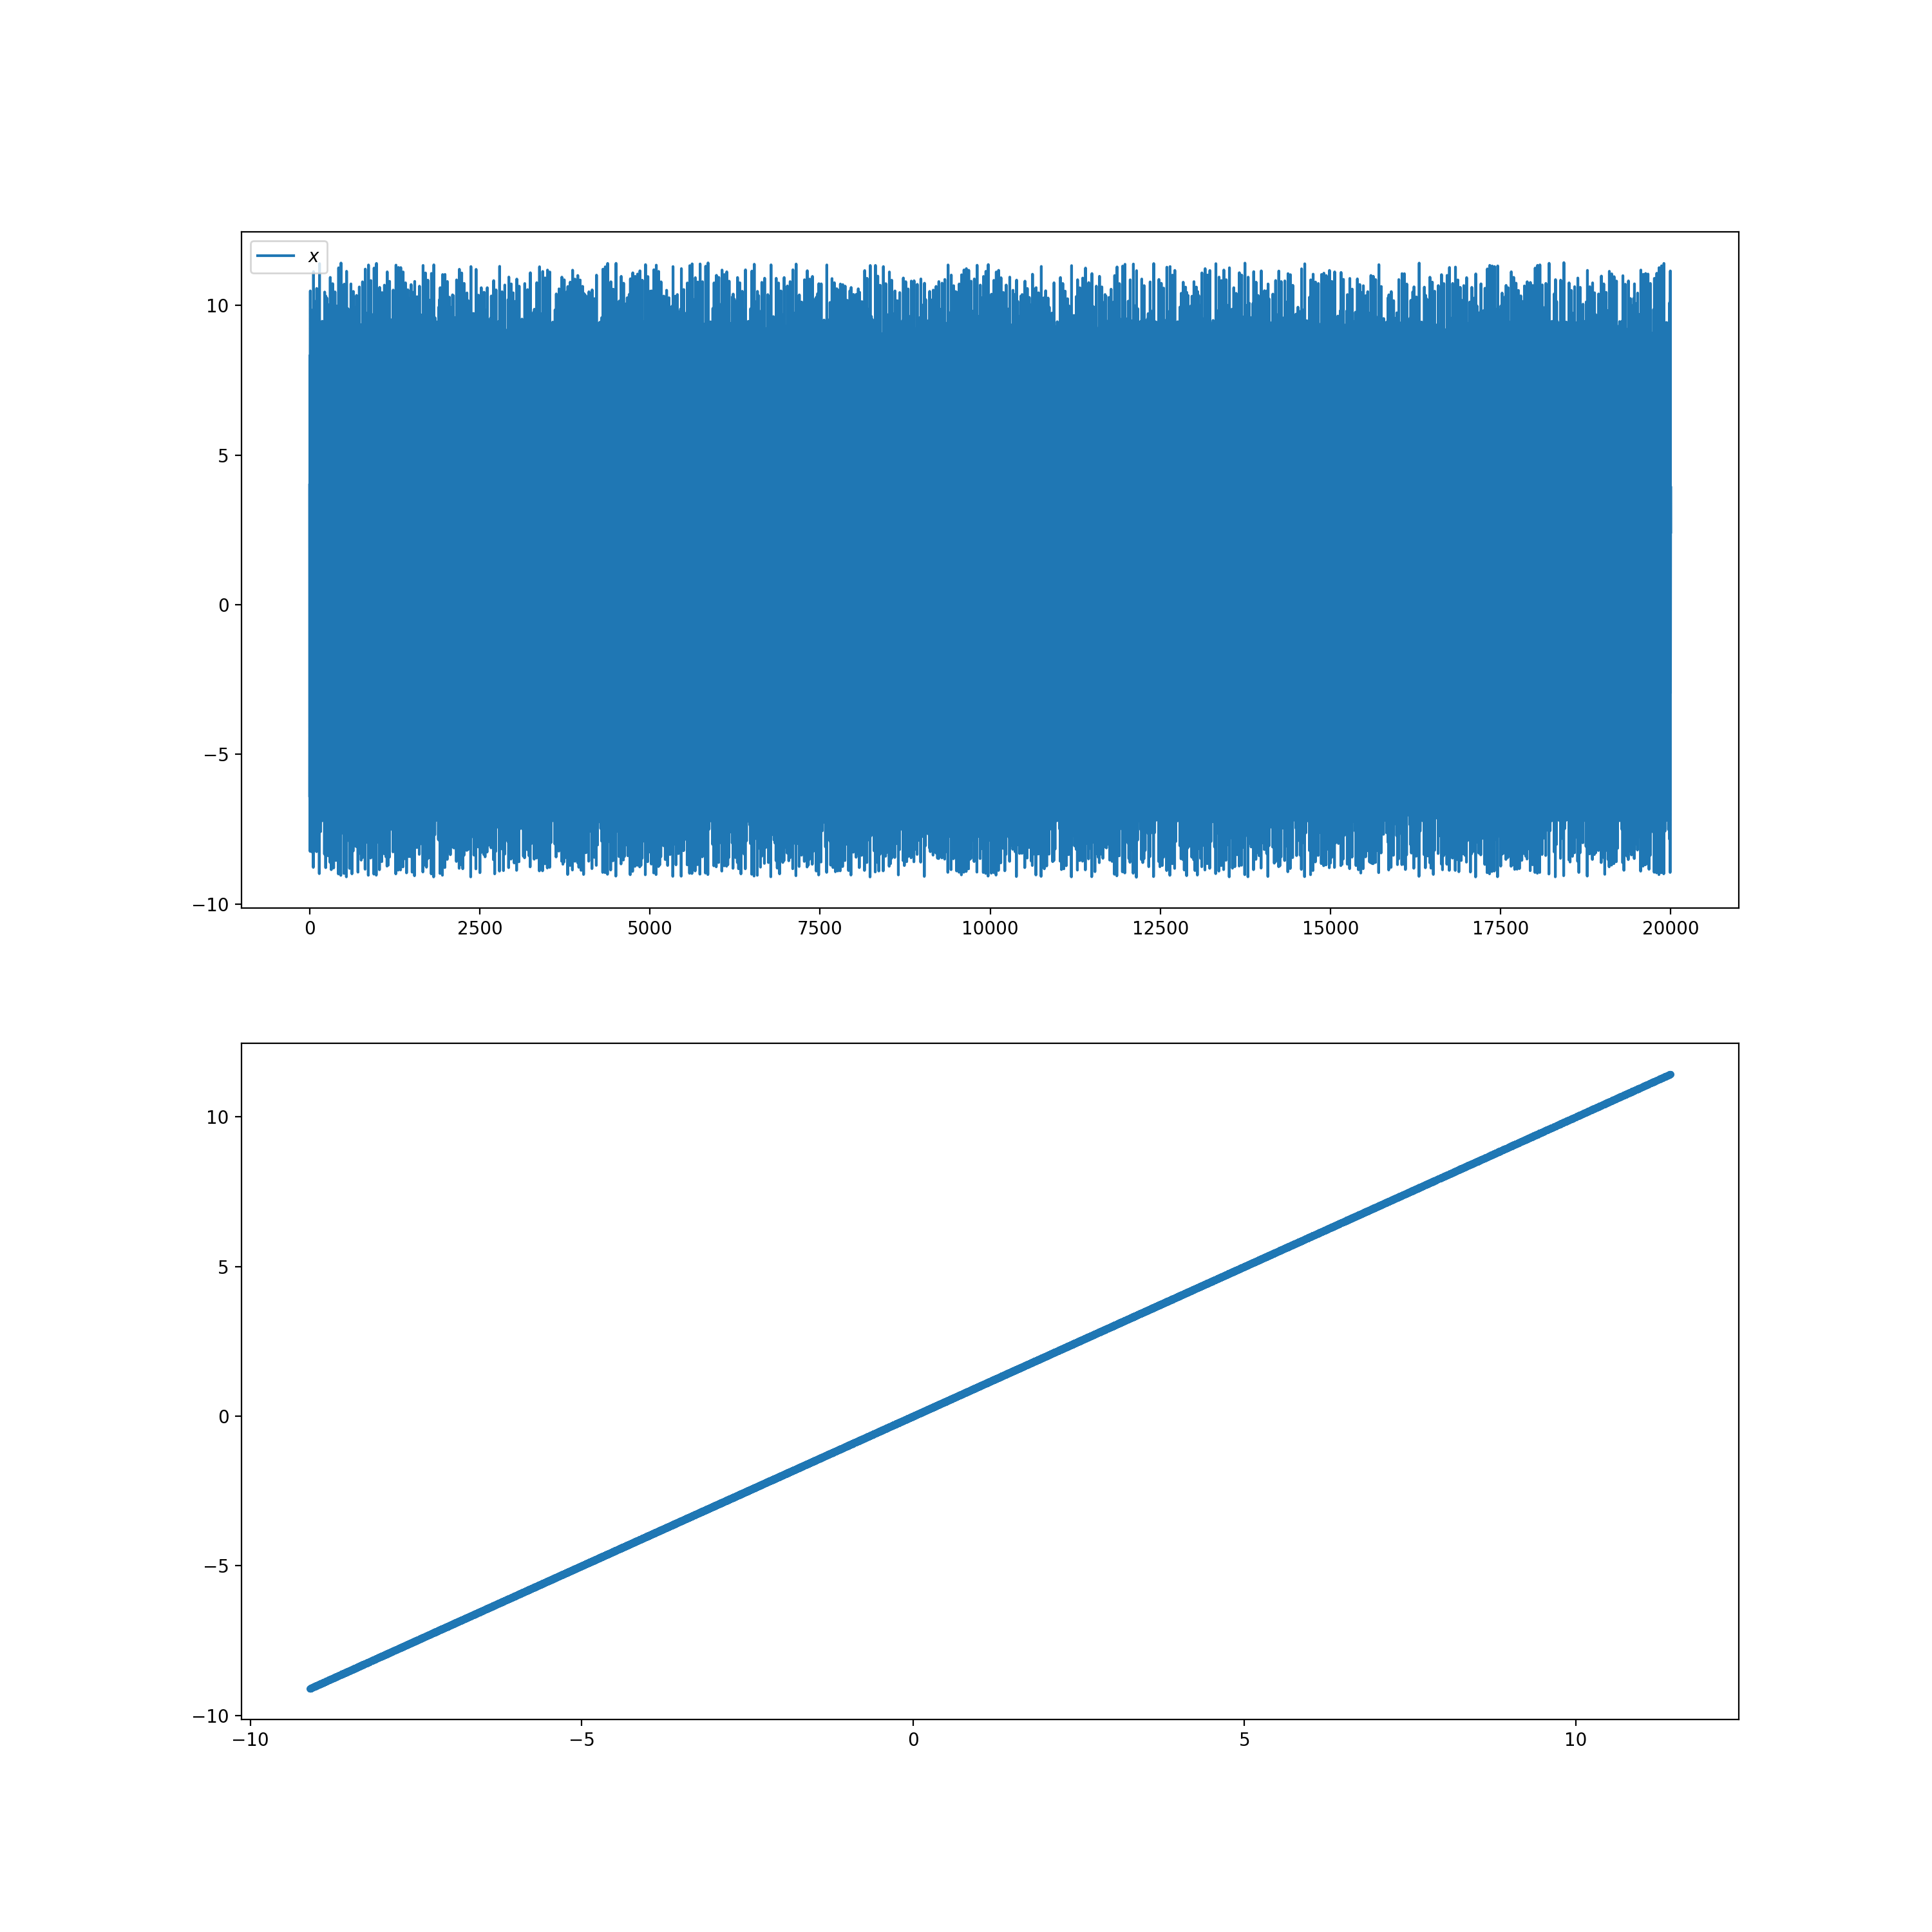

In [9]:
f,[ax1,ax2] = plt.subplots(2,1,figsize=(15,15))
ax1.plot(res[:,0], label='$x$');
ax1.legend()
ax2.plot(res[:,0],res[:,0], '.');

A series atrasadas com valores de $\tau$ pequenos, tendem a ser muito correlacionadas. Portanto a escolha de $\tau$ é importante. Abaixo temos uma figura interativa que nos permite visualizar o atrator do sistema em 3 dimensões para vários valores de $\tau$. Uma das maneiras mais comuns de se estima o melhor valor de $\tau$ é através da [informação mútua](https://en.wikipedia.org/wiki/Mutual_information) entre as séries, queremos encontrar o menor valor de tau, que minimiza a informação mútua.

Para simplicidade de cálculo podemos obter a informação mútual a partir da correlação
$$I=-\frac{1}{2}log(1-\rho^2)$$

Esta aproximação pressupões que ambas as séries têm distribuição Gaussiana.

In [12]:
@interact(tau=widgets.IntSlider(7,0,40,1))
def embed(tau):
    fig = plt.figure()
    ax=fig.gca(projection='3d')
    x,y,z = res[:-2*tau,0],res[tau:-tau,0], res[2*tau:,0]
    mi = MI(x,y)
    ax.plot(x,y,z, '.', alpha=0.5)
    ax.set_title(fr'$\tau={tau}$, Mutual information: {mi}')
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(f'$x+{tau}$')
    ax.set_zlabel(f'$x+{2*tau}$')
    

interactive(children=(IntSlider(value=1, description='tau', max=40), Output()), _dom_classes=('widget-interact…

<IPython.core.display.Javascript object>


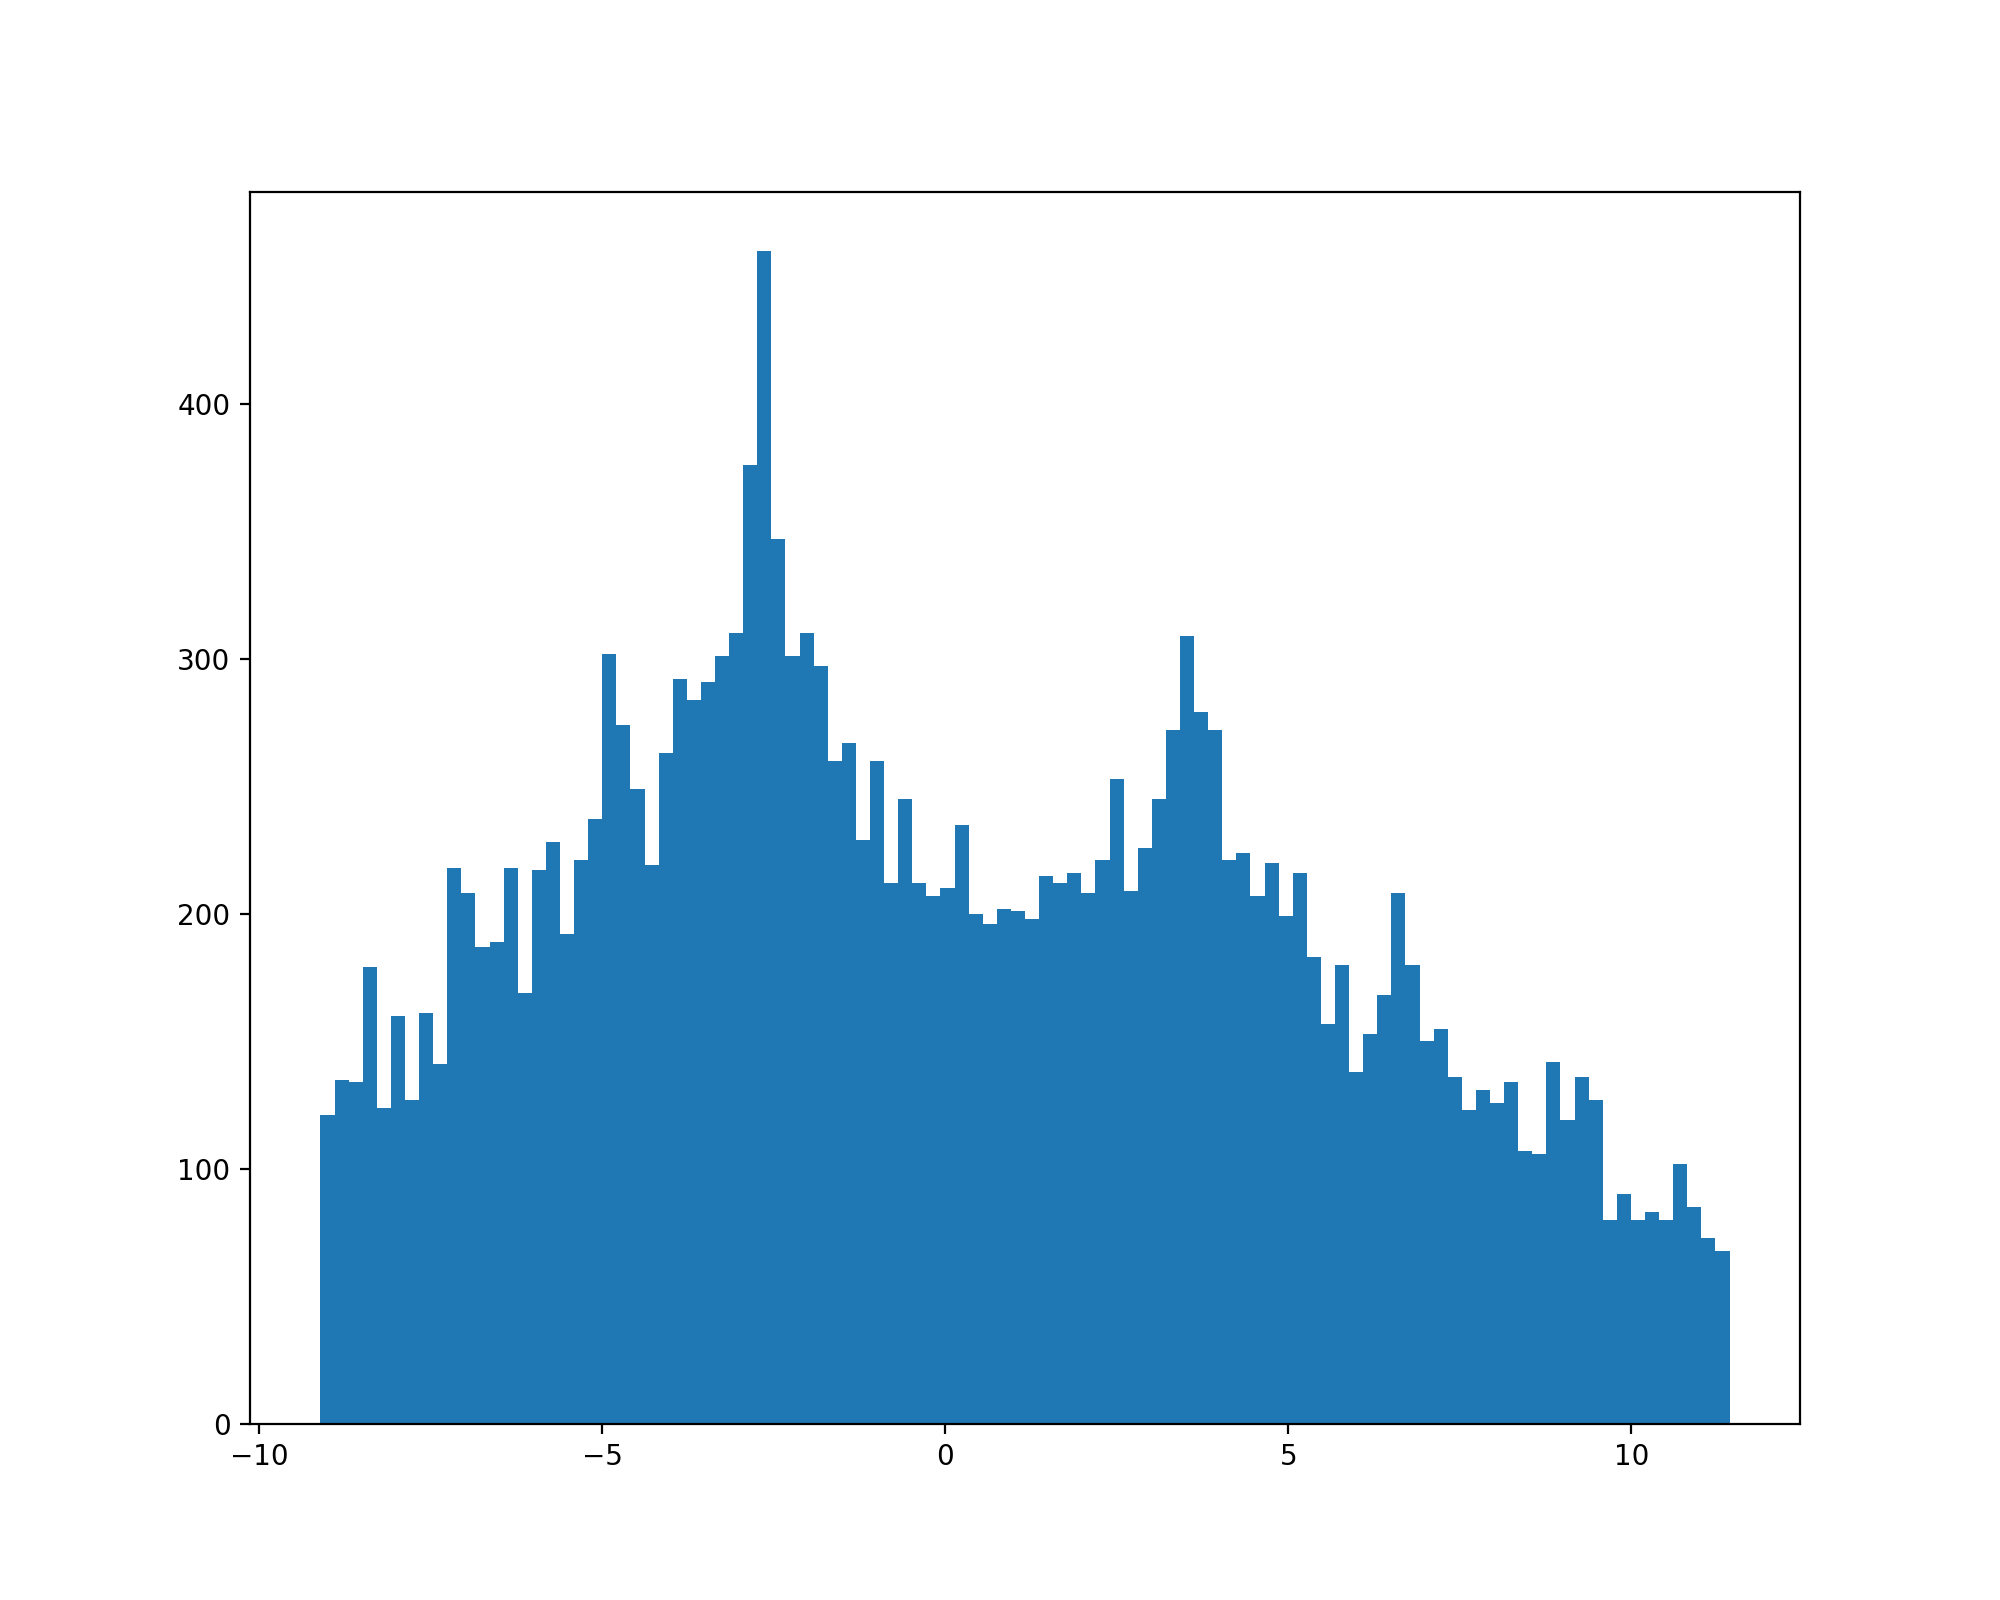

In [14]:
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(res[:,0],bins=100);

<IPython.core.display.Javascript object>


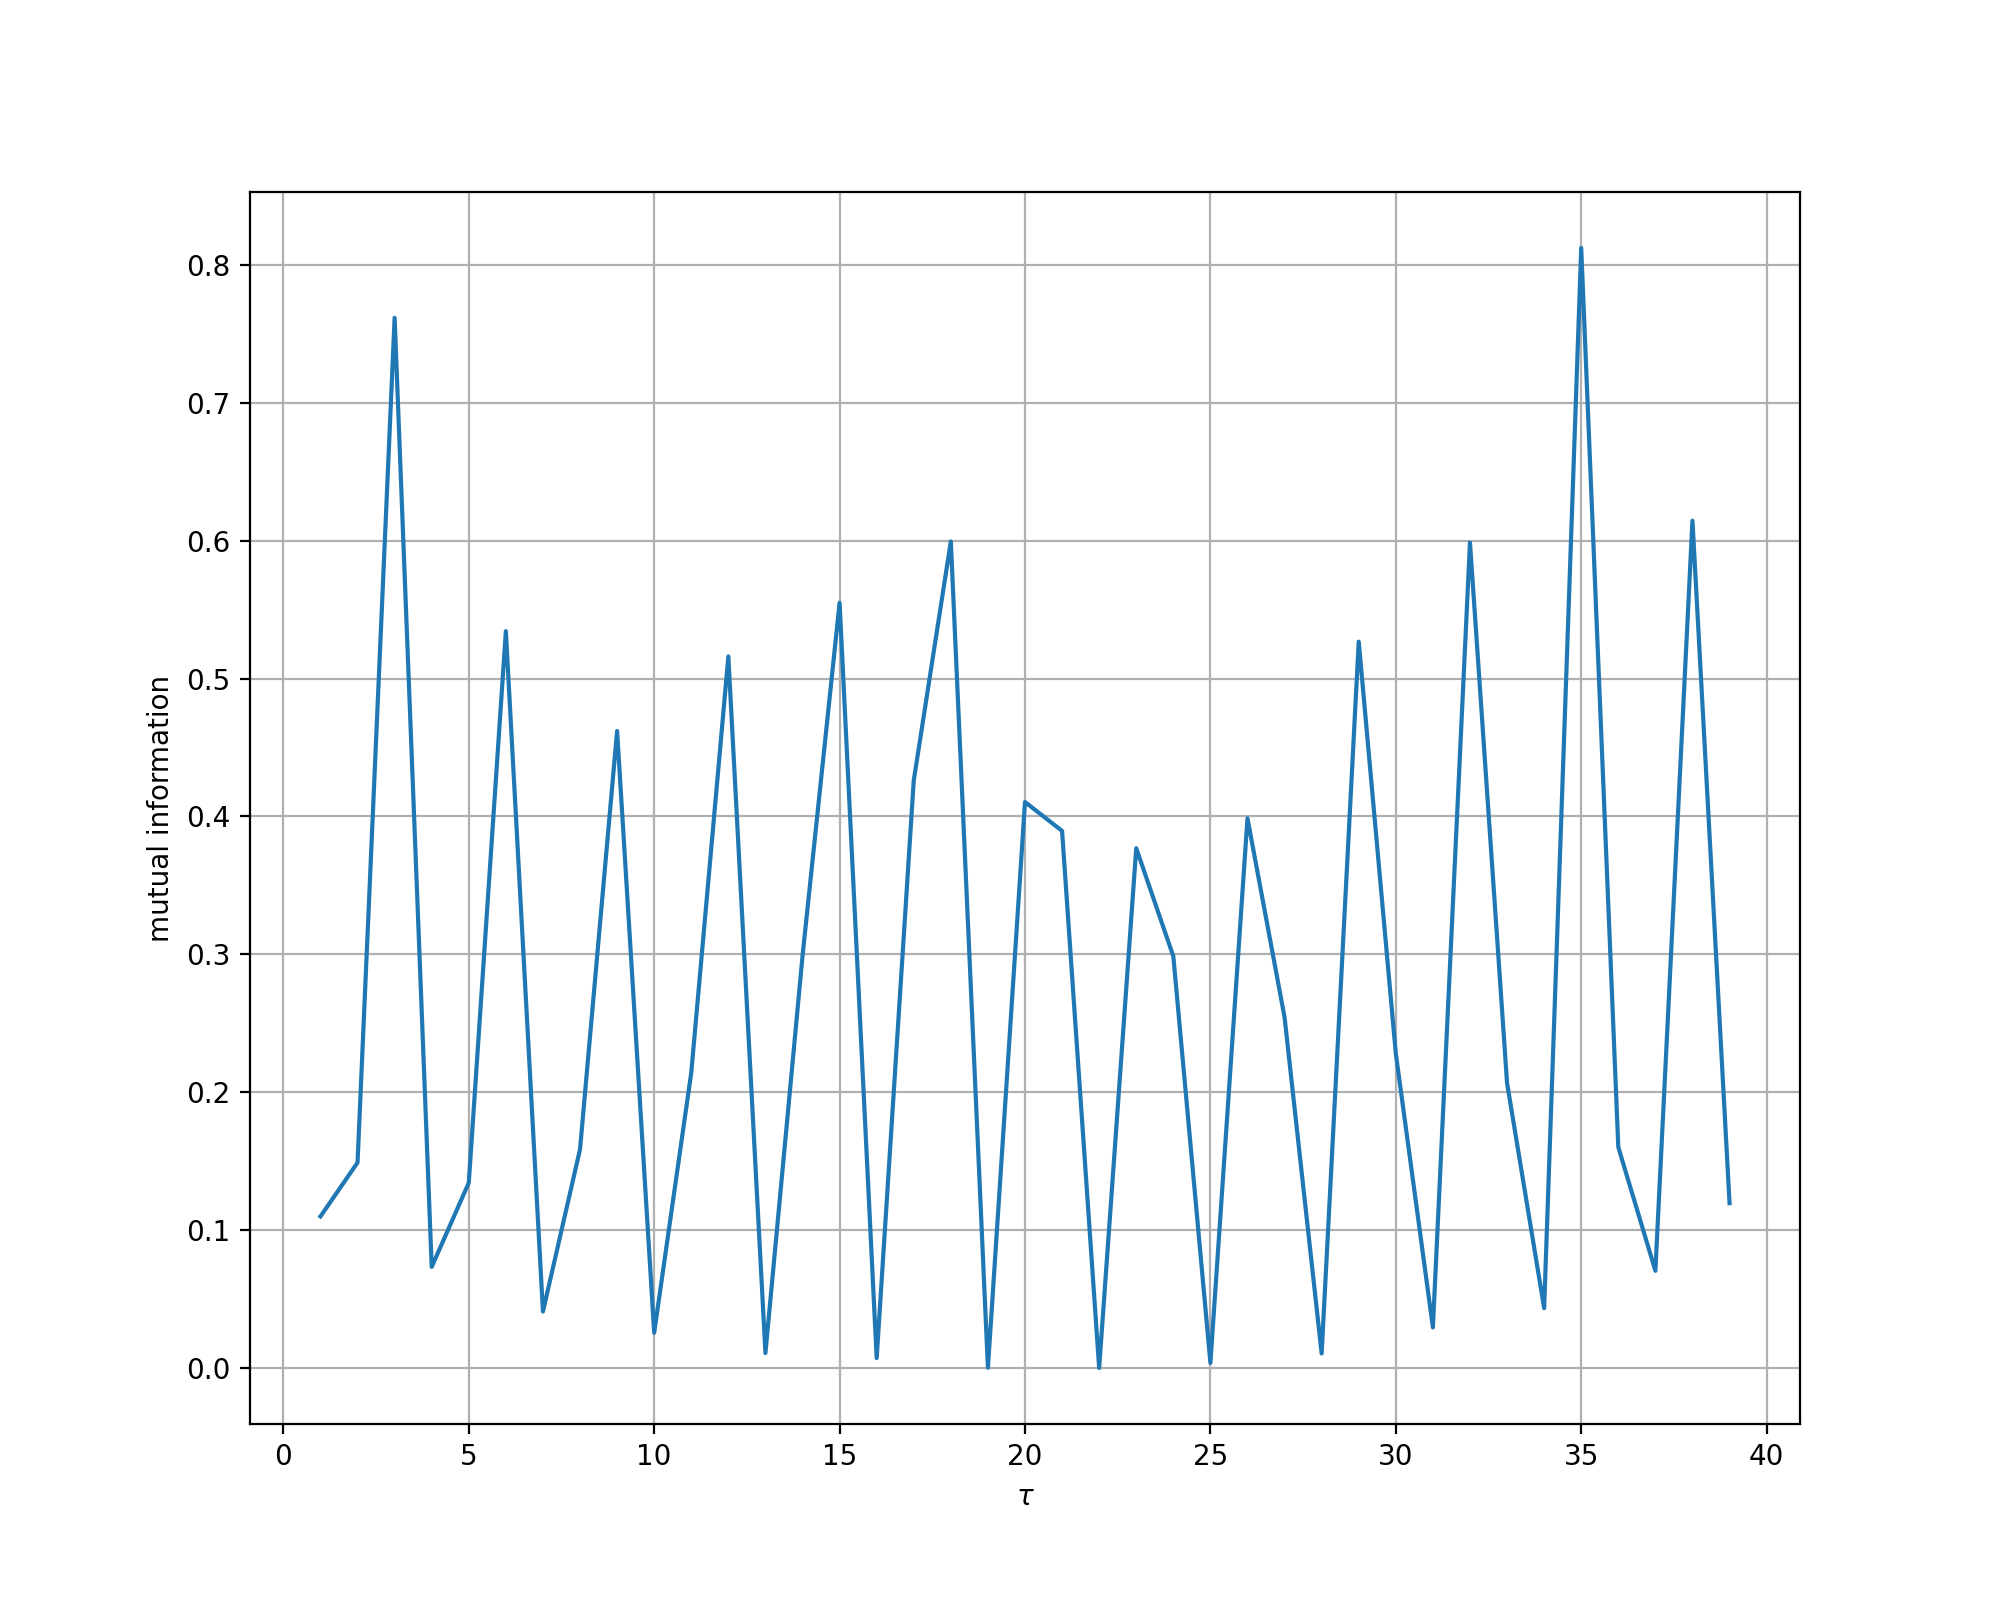

Text(0, 0.5, 'mutual information')

In [19]:
mis = []
for tau in range(1,40):
    mis.append(-0.5*np.log(1-pearsonr(res[:-tau,0],res[tau:,0])[0]**2))
#     mis.append(MI(res[:-tau,0],res[tau:,0]))
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(1,40),mis)
ax.grid()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'mutual information')

## Estimando $m$, a dimensão de embedding

In [17]:
pearsonr(res[:-tau,0],res[tau:,0])

(0.4443157859897356, 0.0)